In [1]:
from torch import nn, optim, float32, LongTensor, uint8
import torch
import numpy as np
import torch.nn.functional as F
from util.plot_tools import show_and_save
from diffusion.sampling import sample_single_image
from dataset.chestxray import ChestXRayDataset
from datahandling.dataloader import get_list_from_txt, extract_annotation_targets, extract_unique_labels, extract_n_single_label_images
from datahandling.transforms import to_numeric_label, to_class_int
from torch.utils.data import DataLoader
from torchvision import datasets, models
import torchvision.transforms as transforms
import os
import ast
import torchvision
import matplotlib.pyplot as plt
from dotenv import  load_dotenv
from diffusers import DDPMScheduler
import timeit

/cluster/home/larsira/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Environment Variables

In [2]:
load_dotenv()
debug = ast.literal_eval(os.getenv("DEBUG"))
db_path = os.getenv("DB_PATH")
img_dir_name = os.getenv("IMG_DIR")
class_file_name = os.getenv("CLASSIFICATION_FILE")
train_list = os.getenv("TRAIN_VAL_LIST")
test_list = os.getenv("TEST_LIST")

device="cpu"
if torch.cuda.is_available():
    device="cuda"

print(device, test_list)

cuda test_list.txt


# Set Constants

In [3]:
NUM_TRAIN_TIMESTEPS = 1000
IMG_SIZE = 128
NUM_GENERATE_IMAGES = 9
BATCH_SIZE=16
WARMUP_STEPS=100
NUM_EPOCHS=100
LEARNING_RATE= 1e-4
MIXED_PRECISION="fp16"
GRADIENT_ACCUMULATION_STEPS=1
NUM_TIMESTEPS = 100

# Load data

In [4]:
img_dir = os.path.join(db_path, img_dir_name)
annotations_file = os.path.join(db_path, class_file_name)
target_file = os.path.join(db_path, "small_file.csv")
extract_n_single_label_images(annotations_file, 500, target_file)

preprocess_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
])

train_dataset = ChestXRayDataset(target_file, img_dir, transform=preprocess_transforms, read_lib="pil", target_transform=to_class_int)
train_loader = DataLoader(train_dataset, BATCH_SIZE)

# Define Model

In [5]:
from diffusers import UNet2DModel
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    num_class_embeds=len(ChestXRayDataset.target_labels),
    norm_num_groups=32,
    class_embed_type="timestep",
   down_block_types=(
        "DownBlock2D", 
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [6]:
# sample_image = train_dataset[0][0].unsqueeze(0)
# img, label = train_dataset[0]

# print("Input shape:", sample_image.shape)
# print("Output shape:", model(sample_image, timestep=0, class_labels=label).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


# Train

100%|██████████| 32/32 [01:05<00:00,  2.06s/it]


------------------------------
train loss epoch: 1: 0.7628
Train Learning Rate EPOCH: 1: 3.2000000000000005e-05


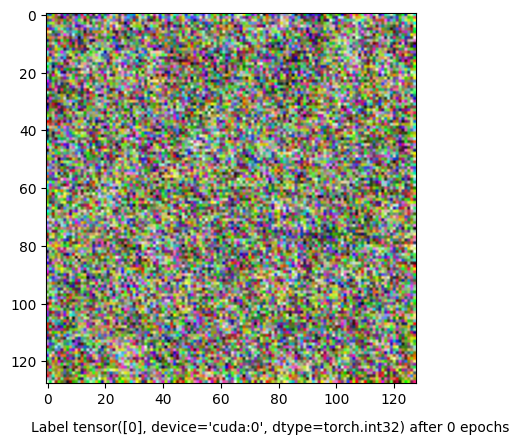

  1%|          | 1/100 [01:43<2:50:23, 103.27s/it]

------------------------------


  2%|▏         | 2/100 [02:01<1:26:55, 53.22s/it] 

------------------------------
train loss epoch: 2: 0.0982
Train Learning Rate EPOCH: 2: 6.400000000000001e-05
------------------------------


  3%|▎         | 3/100 [02:19<1:00:10, 37.23s/it]

------------------------------
train loss epoch: 3: 0.0469
Train Learning Rate EPOCH: 3: 9.6e-05
------------------------------


  4%|▍         | 4/100 [02:37<47:31, 29.71s/it]  

------------------------------
train loss epoch: 4: 0.0397
Train Learning Rate EPOCH: 4: 9.99798718764995e-05
------------------------------


  5%|▌         | 5/100 [02:55<40:26, 25.55s/it]

------------------------------
train loss epoch: 5: 0.0262
Train Learning Rate EPOCH: 5: 9.990759721625005e-05
------------------------------


  6%|▌         | 6/100 [03:14<36:03, 23.02s/it]

------------------------------
train loss epoch: 6: 0.0241
Train Learning Rate EPOCH: 6: 9.978284121609591e-05
------------------------------


  7%|▋         | 7/100 [03:32<33:09, 21.40s/it]

------------------------------
train loss epoch: 7: 0.0243
Train Learning Rate EPOCH: 7: 9.96057350657239e-05
------------------------------


  8%|▊         | 8/100 [03:50<31:11, 20.34s/it]

------------------------------
train loss epoch: 8: 0.0191
Train Learning Rate EPOCH: 8: 9.93764650046766e-05
------------------------------


  9%|▉         | 9/100 [04:08<29:47, 19.64s/it]

------------------------------
train loss epoch: 9: 0.0166
Train Learning Rate EPOCH: 9: 9.909527212650839e-05
------------------------------


 10%|█         | 10/100 [04:26<28:44, 19.16s/it]

------------------------------
train loss epoch: 10: 0.0135
Train Learning Rate EPOCH: 10: 9.876245212525871e-05
------------------------------


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


------------------------------
train loss epoch: 11: 0.0158
Train Learning Rate EPOCH: 11: 9.837835498450891e-05


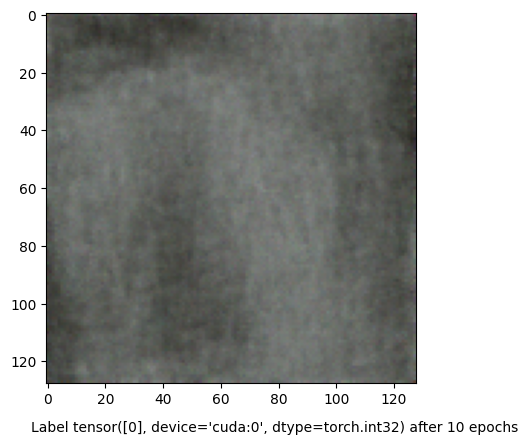

 11%|█         | 11/100 [07:18<1:37:48, 65.94s/it]

------------------------------


 12%|█▏        | 12/100 [07:37<1:15:50, 51.71s/it]

------------------------------
train loss epoch: 12: 0.0178
Train Learning Rate EPOCH: 12: 9.794338460935013e-05
------------------------------


 13%|█▎        | 13/100 [07:55<1:00:15, 41.56s/it]

------------------------------
train loss epoch: 13: 0.0140
Train Learning Rate EPOCH: 13: 9.74579984016486e-05
------------------------------


 14%|█▍        | 14/100 [08:13<49:26, 34.50s/it]  

------------------------------
train loss epoch: 14: 0.0181
Train Learning Rate EPOCH: 14: 9.69227067790556e-05
------------------------------


 15%|█▌        | 15/100 [08:32<41:53, 29.57s/it]

------------------------------
train loss epoch: 15: 0.0145
Train Learning Rate EPOCH: 15: 9.633807263826744e-05
------------------------------


 16%|█▌        | 16/100 [08:50<36:35, 26.14s/it]

------------------------------
train loss epoch: 16: 0.0098
Train Learning Rate EPOCH: 16: 9.570471076310006e-05
------------------------------


 17%|█▋        | 17/100 [09:08<32:47, 23.71s/it]

------------------------------
train loss epoch: 17: 0.0110
Train Learning Rate EPOCH: 17: 9.502328717800082e-05
------------------------------


 18%|█▊        | 18/100 [09:26<30:05, 22.01s/it]

------------------------------
train loss epoch: 18: 0.0124
Train Learning Rate EPOCH: 18: 9.429451844767694e-05
------------------------------


 19%|█▉        | 19/100 [09:44<28:07, 20.83s/it]

------------------------------
train loss epoch: 19: 0.0084
Train Learning Rate EPOCH: 19: 9.351917092357755e-05
------------------------------


 20%|██        | 20/100 [10:02<26:40, 20.01s/it]

------------------------------
train loss epoch: 20: 0.0128
Train Learning Rate EPOCH: 20: 9.269805993802129e-05
------------------------------


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


------------------------------
train loss epoch: 21: 0.0110
Train Learning Rate EPOCH: 21: 9.18320489468172e-05


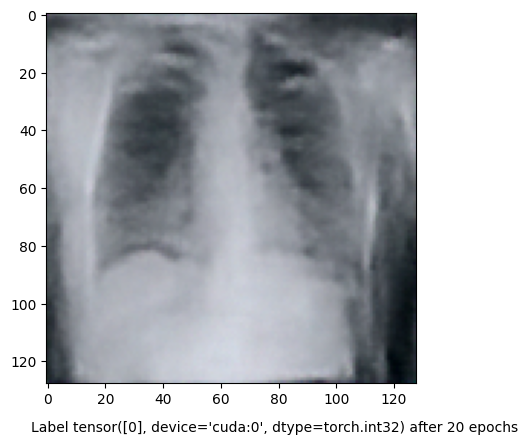

 21%|██        | 21/100 [10:56<39:55, 30.32s/it]

------------------------------


 22%|██▏       | 22/100 [11:15<34:37, 26.64s/it]

------------------------------
train loss epoch: 22: 0.0114
Train Learning Rate EPOCH: 22: 9.092204862128042e-05
------------------------------


 23%|██▎       | 23/100 [11:33<30:53, 24.07s/it]

------------------------------
train loss epoch: 23: 0.0128
Train Learning Rate EPOCH: 23: 8.996901589059729e-05
------------------------------


 24%|██▍       | 24/100 [11:51<28:12, 22.27s/it]

------------------------------
train loss epoch: 24: 0.0106
Train Learning Rate EPOCH: 24: 8.897395293554727e-05
------------------------------


 25%|██▌       | 25/100 [12:09<26:16, 21.02s/it]

------------------------------
train loss epoch: 25: 0.0120
Train Learning Rate EPOCH: 25: 8.793790613463955e-05
------------------------------


 26%|██▌       | 26/100 [12:51<33:47, 27.40s/it]

------------------------------
train loss epoch: 26: 0.0086
Train Learning Rate EPOCH: 26: 8.686196496377252e-05
------------------------------


 27%|██▋       | 27/100 [13:11<30:37, 25.17s/it]

------------------------------
train loss epoch: 27: 0.0087
Train Learning Rate EPOCH: 27: 8.574726085057357e-05
------------------------------


 28%|██▊       | 28/100 [13:29<27:39, 23.05s/it]

------------------------------
train loss epoch: 28: 0.0070
Train Learning Rate EPOCH: 28: 8.459496598462344e-05
------------------------------


 29%|██▉       | 29/100 [13:47<25:30, 21.55s/it]

------------------------------
train loss epoch: 29: 0.0091
Train Learning Rate EPOCH: 29: 8.340629208481674e-05
------------------------------


 30%|███       | 30/100 [14:05<23:56, 20.52s/it]

------------------------------
train loss epoch: 30: 0.0080
Train Learning Rate EPOCH: 30: 8.218248912515442e-05
------------------------------


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


------------------------------
train loss epoch: 31: 0.0088
Train Learning Rate EPOCH: 31: 8.092484402030853e-05


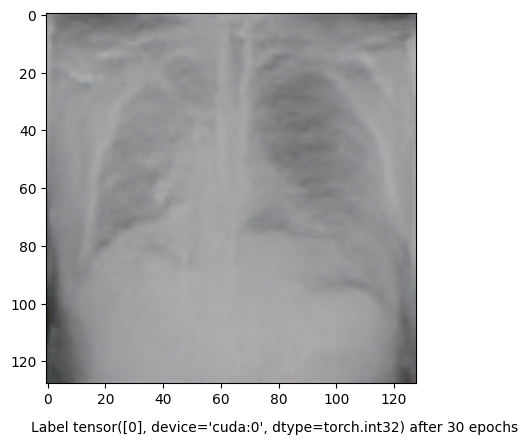

 31%|███       | 31/100 [15:00<35:27, 30.83s/it]

------------------------------


 32%|███▏      | 32/100 [15:18<30:35, 27.00s/it]

------------------------------
train loss epoch: 32: 0.0100
Train Learning Rate EPOCH: 32: 7.963467927234103e-05
------------------------------


 33%|███▎      | 33/100 [15:36<27:09, 24.32s/it]

------------------------------
train loss epoch: 33: 0.0092
Train Learning Rate EPOCH: 33: 7.831335158000015e-05
------------------------------


 34%|███▍      | 34/100 [16:18<32:26, 29.49s/it]

------------------------------
train loss epoch: 34: 0.0106
Train Learning Rate EPOCH: 34: 7.69622504120565e-05
------------------------------


 35%|███▌      | 35/100 [16:36<28:23, 26.20s/it]

------------------------------
train loss epoch: 35: 0.0080
Train Learning Rate EPOCH: 35: 7.558279654617912e-05
------------------------------


 36%|███▌      | 36/100 [16:55<25:36, 24.01s/it]

------------------------------
train loss epoch: 36: 0.0090
Train Learning Rate EPOCH: 36: 7.41764405748881e-05
------------------------------


 37%|███▋      | 37/100 [17:14<23:26, 22.32s/it]

------------------------------
train loss epoch: 37: 0.0089
Train Learning Rate EPOCH: 37: 7.274466138015479e-05
------------------------------


 38%|███▊      | 38/100 [17:32<21:46, 21.07s/it]

------------------------------
train loss epoch: 38: 0.0082
Train Learning Rate EPOCH: 38: 7.128896457825364e-05
------------------------------


 39%|███▉      | 39/100 [17:50<20:30, 20.17s/it]

------------------------------
train loss epoch: 39: 0.0078
Train Learning Rate EPOCH: 39: 6.981088093650104e-05
------------------------------


 40%|████      | 40/100 [18:08<19:33, 19.55s/it]

------------------------------
train loss epoch: 40: 0.0092
Train Learning Rate EPOCH: 40: 6.831196476354614e-05
------------------------------


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


------------------------------
train loss epoch: 41: 0.0087
Train Learning Rate EPOCH: 41: 6.679379227490619e-05


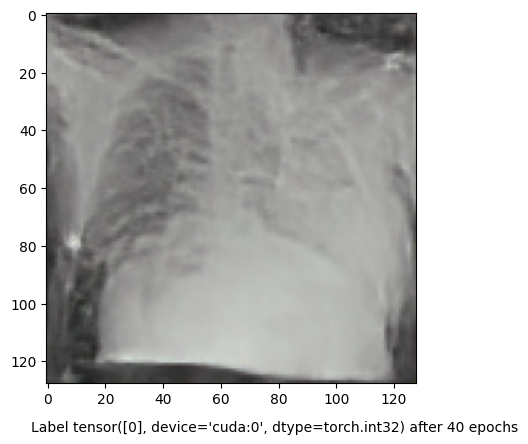

 41%|████      | 41/100 [19:02<29:22, 29.87s/it]

------------------------------


 42%|████▏     | 42/100 [19:20<25:26, 26.33s/it]

------------------------------
train loss epoch: 42: 0.0085
Train Learning Rate EPOCH: 42: 6.525795993546537e-05
------------------------------


 43%|████▎     | 43/100 [19:46<25:03, 26.37s/it]

------------------------------
train loss epoch: 43: 0.0084
Train Learning Rate EPOCH: 43: 6.370608278068e-05
------------------------------


 44%|████▍     | 44/100 [20:05<22:19, 23.92s/it]

------------------------------
train loss epoch: 44: 0.0073
Train Learning Rate EPOCH: 44: 6.213979271825537e-05
------------------------------


 45%|████▌     | 45/100 [20:23<20:19, 22.17s/it]

------------------------------
train loss epoch: 45: 0.0066
Train Learning Rate EPOCH: 45: 6.056073681208038e-05
------------------------------


 46%|████▌     | 46/100 [20:41<18:50, 20.94s/it]

------------------------------
train loss epoch: 46: 0.0068
Train Learning Rate EPOCH: 46: 5.8970575550224206e-05
------------------------------


 47%|████▋     | 47/100 [20:59<17:44, 20.08s/it]

------------------------------
train loss epoch: 47: 0.0067
Train Learning Rate EPOCH: 47: 5.7370981098816725e-05
------------------------------


 48%|████▊     | 48/100 [21:17<16:53, 19.48s/it]

------------------------------
train loss epoch: 48: 0.0084
Train Learning Rate EPOCH: 48: 5.5763635543648377e-05
------------------------------


 49%|████▉     | 49/100 [21:35<16:12, 19.06s/it]

------------------------------
train loss epoch: 49: 0.0081
Train Learning Rate EPOCH: 49: 5.4150229121339036e-05
------------------------------


 50%|█████     | 50/100 [21:53<15:38, 18.77s/it]

------------------------------
train loss epoch: 50: 0.0070
Train Learning Rate EPOCH: 50: 5.2532458441935636e-05
------------------------------


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


------------------------------
train loss epoch: 51: 0.0067
Train Learning Rate EPOCH: 51: 5.091202470480758e-05


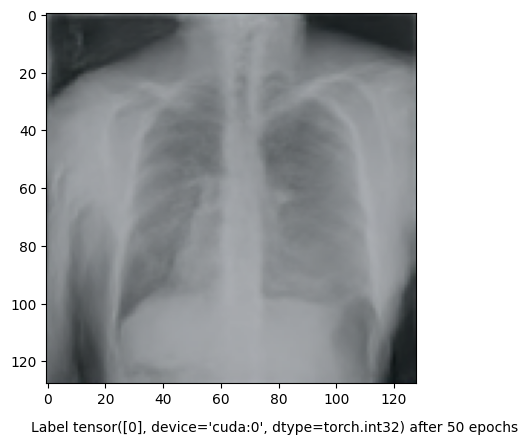

 51%|█████     | 51/100 [22:48<24:11, 29.62s/it]

------------------------------


 52%|█████▏    | 52/100 [23:06<20:56, 26.17s/it]

------------------------------
train loss epoch: 52: 0.0058
Train Learning Rate EPOCH: 52: 4.929063190971633e-05
------------------------------


 53%|█████▎    | 53/100 [23:24<18:35, 23.74s/it]

------------------------------
train loss epoch: 53: 0.0088
Train Learning Rate EPOCH: 53: 4.7669985064940046e-05
------------------------------


 54%|█████▍    | 54/100 [23:42<16:53, 22.04s/it]

------------------------------
train loss epoch: 54: 0.0094
Train Learning Rate EPOCH: 54: 4.605178839433788e-05
------------------------------


 55%|█████▌    | 55/100 [24:00<15:38, 20.84s/it]

------------------------------
train loss epoch: 55: 0.0078
Train Learning Rate EPOCH: 55: 4.443774354523882e-05
------------------------------


 56%|█████▌    | 56/100 [24:18<14:40, 20.02s/it]

------------------------------
train loss epoch: 56: 0.0054
Train Learning Rate EPOCH: 56: 4.2829547799040375e-05
------------------------------


 57%|█████▋    | 57/100 [24:37<13:55, 19.43s/it]

------------------------------
train loss epoch: 57: 0.0069
Train Learning Rate EPOCH: 57: 4.122889228639791e-05
------------------------------


 58%|█████▊    | 58/100 [24:55<13:19, 19.02s/it]

------------------------------
train loss epoch: 58: 0.0068
Train Learning Rate EPOCH: 58: 3.963746020888226e-05
------------------------------


 59%|█████▉    | 59/100 [25:13<12:48, 18.74s/it]

------------------------------
train loss epoch: 59: 0.0065
Train Learning Rate EPOCH: 59: 3.805692506897505e-05
------------------------------


 60%|██████    | 60/100 [25:31<12:21, 18.54s/it]

------------------------------
train loss epoch: 60: 0.0077
Train Learning Rate EPOCH: 60: 3.6488948910263584e-05
------------------------------


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


------------------------------
train loss epoch: 61: 0.0079
Train Learning Rate EPOCH: 61: 3.4935180569685225e-05


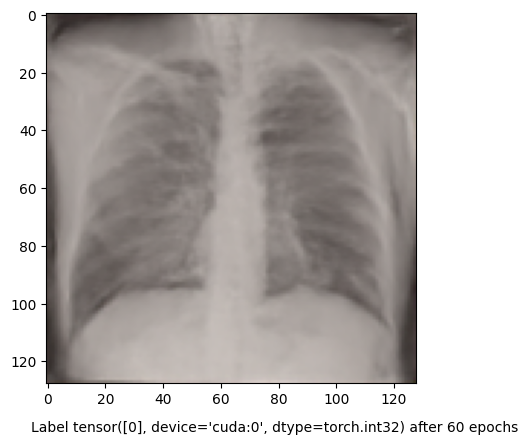

 61%|██████    | 61/100 [26:25<18:57, 29.17s/it]

------------------------------


 62%|██████▏   | 62/100 [26:43<16:21, 25.83s/it]

------------------------------
train loss epoch: 62: 0.0084
Train Learning Rate EPOCH: 62: 3.3397253943659855e-05
------------------------------


 63%|██████▎   | 63/100 [27:01<14:29, 23.50s/it]

------------------------------
train loss epoch: 63: 0.0073
Train Learning Rate EPOCH: 63: 3.187678626993307e-05
------------------------------


 64%|██████▍   | 64/100 [27:19<13:07, 21.87s/it]

------------------------------
train loss epoch: 64: 0.0078
Train Learning Rate EPOCH: 64: 3.0375376426937153e-05
------------------------------


 65%|██████▌   | 65/100 [27:37<12:05, 20.73s/it]

------------------------------
train loss epoch: 65: 0.0071
Train Learning Rate EPOCH: 65: 2.8894603252458408e-05
------------------------------


 66%|██████▌   | 66/100 [27:55<11:17, 19.93s/it]

------------------------------
train loss epoch: 66: 0.0064
Train Learning Rate EPOCH: 66: 2.7436023883378303e-05
------------------------------


 67%|██████▋   | 67/100 [28:13<10:39, 19.39s/it]

------------------------------
train loss epoch: 67: 0.0065
Train Learning Rate EPOCH: 67: 2.6001172118234874e-05
------------------------------


 68%|██████▊   | 68/100 [28:31<10:07, 19.00s/it]

------------------------------
train loss epoch: 68: 0.0073
Train Learning Rate EPOCH: 68: 2.4591556804325898e-05
------------------------------


 69%|██████▉   | 69/100 [29:08<12:36, 24.40s/it]

------------------------------
train loss epoch: 69: 0.0059
Train Learning Rate EPOCH: 69: 2.3208660251050158e-05
------------------------------


 70%|███████   | 70/100 [29:29<11:36, 23.21s/it]

------------------------------
train loss epoch: 70: 0.0080
Train Learning Rate EPOCH: 70: 2.1853936671155127e-05
------------------------------


100%|██████████| 32/32 [00:18<00:00,  1.69it/s]


------------------------------
train loss epoch: 71: 0.0077
Train Learning Rate EPOCH: 71: 2.052881065153009e-05


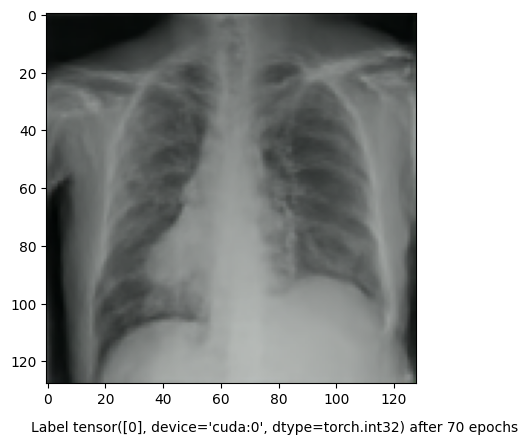

 71%|███████   | 71/100 [30:25<16:01, 33.14s/it]

------------------------------


 72%|███████▏  | 72/100 [30:44<13:30, 28.95s/it]

------------------------------
train loss epoch: 72: 0.0070
Train Learning Rate EPOCH: 72: 1.9234675655153333e-05
------------------------------


 73%|███████▎  | 73/100 [31:26<14:43, 32.71s/it]

------------------------------
train loss epoch: 73: 0.0050
Train Learning Rate EPOCH: 73: 1.7972892555767773e-05
------------------------------


 74%|███████▍  | 74/100 [31:44<12:17, 28.38s/it]

------------------------------
train loss epoch: 74: 0.0101
Train Learning Rate EPOCH: 74: 1.6744788206827038e-05
------------------------------


 75%|███████▌  | 75/100 [32:02<10:32, 25.30s/it]

------------------------------
train loss epoch: 75: 0.0060
Train Learning Rate EPOCH: 75: 1.555165404621567e-05
------------------------------


 76%|███████▌  | 76/100 [32:20<09:15, 23.15s/it]

------------------------------
train loss epoch: 76: 0.0057
Train Learning Rate EPOCH: 76: 1.439474473821188e-05
------------------------------


 77%|███████▋  | 77/100 [32:38<08:17, 21.62s/it]

------------------------------
train loss epoch: 77: 0.0060
Train Learning Rate EPOCH: 77: 1.3275276854119739e-05
------------------------------


 78%|███████▊  | 78/100 [32:56<07:32, 20.55s/it]

------------------------------
train loss epoch: 78: 0.0051
Train Learning Rate EPOCH: 78: 1.2194427592959389e-05
------------------------------


 79%|███████▉  | 79/100 [34:33<15:10, 43.36s/it]

------------------------------
train loss epoch: 79: 0.0072
Train Learning Rate EPOCH: 79: 1.1153333543559452e-05
------------------------------


 80%|████████  | 80/100 [34:51<11:58, 35.93s/it]

------------------------------
train loss epoch: 80: 0.0066
Train Learning Rate EPOCH: 80: 1.0153089489354257e-05
------------------------------


100%|██████████| 32/32 [00:46<00:00,  1.45s/it]


------------------------------
train loss epoch: 81: 0.0080
Train Learning Rate EPOCH: 81: 9.194747257142212e-06


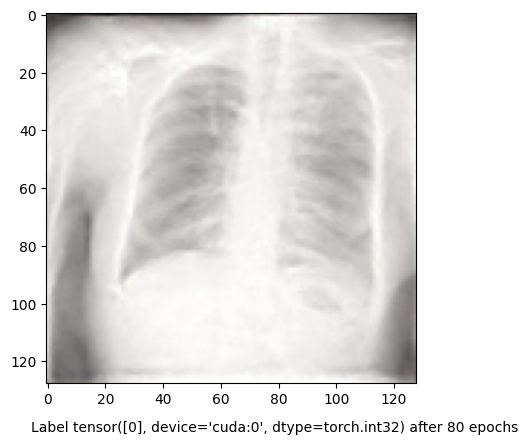

 81%|████████  | 81/100 [36:14<15:49, 49.99s/it]

------------------------------


 82%|████████▏ | 82/100 [36:33<12:09, 40.53s/it]

------------------------------
train loss epoch: 82: 0.0085
Train Learning Rate EPOCH: 82: 8.279314611016148e-06
------------------------------


 83%|████████▎ | 83/100 [36:51<09:35, 33.83s/it]

------------------------------
train loss epoch: 83: 0.0060
Train Learning Rate EPOCH: 83: 7.407754192628657e-06
------------------------------


 84%|████████▍ | 84/100 [37:09<07:45, 29.12s/it]

------------------------------
train loss epoch: 84: 0.0058
Train Learning Rate EPOCH: 84: 6.580982508906852e-06
------------------------------


 85%|████████▌ | 85/100 [37:39<07:20, 29.37s/it]

------------------------------
train loss epoch: 85: 0.0066
Train Learning Rate EPOCH: 85: 5.7998689682810746e-06
------------------------------


 86%|████████▌ | 86/100 [40:11<15:26, 66.18s/it]

------------------------------
train loss epoch: 86: 0.0066
Train Learning Rate EPOCH: 86: 5.065234966440885e-06
------------------------------


 87%|████████▋ | 87/100 [40:30<11:17, 52.08s/it]

------------------------------
train loss epoch: 87: 0.0072
Train Learning Rate EPOCH: 87: 4.3778530225798755e-06
------------------------------


 88%|████████▊ | 88/100 [40:48<08:22, 41.90s/it]

------------------------------
train loss epoch: 88: 0.0059
Train Learning Rate EPOCH: 88: 3.7384459670375626e-06
------------------------------


 89%|████████▉ | 89/100 [41:07<06:22, 34.78s/it]

------------------------------
train loss epoch: 89: 0.0056
Train Learning Rate EPOCH: 89: 3.1476861811925553e-06
------------------------------


 90%|█████████ | 90/100 [41:25<04:57, 29.79s/it]

------------------------------
train loss epoch: 90: 0.0070
Train Learning Rate EPOCH: 90: 2.606194890406366e-06
------------------------------


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


------------------------------
train loss epoch: 91: 0.0058
Train Learning Rate EPOCH: 91: 2.11454151076137e-06


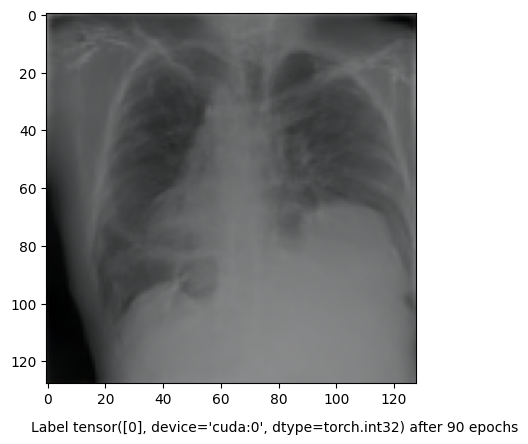

 91%|█████████ | 91/100 [42:24<05:48, 38.68s/it]

------------------------------


 92%|█████████▏| 92/100 [42:42<04:19, 32.48s/it]

------------------------------
train loss epoch: 92: 0.0066
Train Learning Rate EPOCH: 92: 1.6732430502798157e-06
------------------------------


 93%|█████████▎| 93/100 [43:00<03:17, 28.15s/it]

------------------------------
train loss epoch: 93: 0.0059
Train Learning Rate EPOCH: 93: 1.2827635652536473e-06
------------------------------


 94%|█████████▍| 94/100 [43:18<02:30, 25.11s/it]

------------------------------
train loss epoch: 94: 0.0060
Train Learning Rate EPOCH: 94: 9.435136722567405e-07
------------------------------


 95%|█████████▌| 95/100 [43:36<01:54, 22.99s/it]

------------------------------
train loss epoch: 95: 0.0070
Train Learning Rate EPOCH: 95: 6.558501163527964e-07
------------------------------


 96%|█████████▌| 96/100 [43:54<01:26, 21.51s/it]

------------------------------
train loss epoch: 96: 0.0063
Train Learning Rate EPOCH: 96: 4.2007539595280143e-07
------------------------------


 97%|█████████▋| 97/100 [44:12<01:01, 20.47s/it]

------------------------------
train loss epoch: 97: 0.0056
Train Learning Rate EPOCH: 97: 2.364374447168305e-07
------------------------------


 98%|█████████▊| 98/100 [44:30<00:39, 19.76s/it]

------------------------------
train loss epoch: 98: 0.0045
Train Learning Rate EPOCH: 98: 1.0512937083432262e-07
------------------------------


 99%|█████████▉| 99/100 [44:49<00:19, 19.25s/it]

------------------------------
train loss epoch: 99: 0.0077
Train Learning Rate EPOCH: 99: 2.628925395731785e-08
------------------------------


100%|██████████| 100/100 [45:07<00:00, 27.07s/it]

------------------------------
train loss epoch: 100: 0.0066
Train Learning Rate EPOCH: 100: 0.0
------------------------------


In [7]:
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=(len(train_loader) * NUM_EPOCHS)
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_loader, lr_scheduler)
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)

start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss=0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images=batch[0].to(device)
        labels=batch[1].flatten().to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size=len(clean_images)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False, class_labels=labels)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx+1)

    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"train loss epoch: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    if epoch%10 == 0:
        sample_single_image(model, IMG_SIZE, device, NUM_TRAIN_TIMESTEPS, ChestXRayDataset.target_labels[0], ChestXRayDataset.target_labels, epoch)
        #sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print("-"*30)